# ThoughtLink — Wavelet Feature Analysis

Training and evaluation using DWT (Discrete Wavelet Transform) features.

**Feature set**: Band power (24) + Hjorth (18) + Time domain (24) + **Wavelet (72)** = **138 features**

Wavelet decomposition at 500 Hz with db4, level 5:
- D5: 7.8-15.6 Hz (mu rhythm)
- D4: 15.6-31.25 Hz (beta rhythm)
- D3: 31.25-62.5 Hz (low gamma)
- A5: 0-7.8 Hz (theta/delta)

Stats per level per channel: energy, entropy, std

In [ ]:
import sys
import json
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, cohen_kappa_score,
    accuracy_score, f1_score, precision_score, recall_score,
)

sys.path.insert(0, str(Path('.').resolve().parent / 'src'))

from thoughtlink.data.loader import load_all, CLASS_NAMES
from thoughtlink.data.splitter import split_by_subject
from thoughtlink.preprocessing.eeg import preprocess_all
from thoughtlink.preprocessing.windowing import windows_from_samples
from thoughtlink.features.eeg_features import extract_features_from_windows
from thoughtlink.models.baseline import build_baselines
from thoughtlink.models.hierarchical import HierarchicalClassifier, RELAX_IDX

results_dir = Path('../results')
sns.set_theme(style='whitegrid', font_scale=1.1)
%matplotlib inline

## 1. Load, Preprocess, Extract Features (with Wavelets)

In [2]:
samples = load_all()
train_samples, test_samples = split_by_subject(samples, test_size=0.2)

train_subjects = sorted(set(s['subject_id'] for s in train_samples))
test_subjects = sorted(set(s['subject_id'] for s in test_samples))
print(f'Train subjects: {train_subjects}')
print(f'Test subject:   {test_subjects}')

Fetching 903 files:   0%|          | 0/903 [00:00<?, ?it/s]

Loaded 900 samples from /Users/david.camachob/Documents/thoughtlink/notebooks/data/raw
Classes: ['Both Fists', 'Left Fist', 'Relax', 'Right Fist', 'Tongue Tapping']
Subjects: 6
Split: 5 train subjects (810 samples), 1 test subjects (90 samples)
Train subjects: ['2a456f03', '37dfbd76', '4c2ea012', 'a5136953', 'd696086d']
Test subject:   ['1a3cd681']


In [3]:
preprocess_all(train_samples)
preprocess_all(test_samples)

X_train_win, y_train, _ = windows_from_samples(train_samples)
X_test_win, y_test, _ = windows_from_samples(test_samples)
print(f'Windows — Train: {X_train_win.shape}, Test: {X_test_win.shape}')

Preprocessed 100/810 samples
Preprocessed 200/810 samples
Preprocessed 300/810 samples
Preprocessed 400/810 samples
Preprocessed 500/810 samples
Preprocessed 600/810 samples
Preprocessed 700/810 samples
Preprocessed 800/810 samples
Windows — Train: (12150, 500, 6), Test: (1350, 500, 6)


In [4]:
t0 = time.time()
X_train = extract_features_from_windows(X_train_win, include_time_domain=True, include_wavelet=True)
X_test = extract_features_from_windows(X_test_win, include_time_domain=True, include_wavelet=True)
feat_time = time.time() - t0

print(f'Feature vector: {X_train.shape[1]} dimensions')
print(f'  Band power:   24 (4 bands x 6 ch)')
print(f'  Hjorth:       18 (3 params x 6 ch)')
print(f'  Time domain:  24 (4 stats x 6 ch)')
print(f'  Wavelet DWT:  72 (3 stats x 4 levels x 6 ch)')
print(f'  Total:        {X_train.shape[1]}')
print(f'Extraction time: {feat_time:.1f}s')

Feature vector: 138 dimensions
  Band power:   24 (4 bands x 6 ch)
  Hjorth:       18 (3 params x 6 ch)
  Time domain:  24 (4 stats x 6 ch)
  Wavelet DWT:  72 (3 stats x 4 levels x 6 ch)
  Total:        138
Extraction time: 7.6s


## 2. Train & Evaluate All Models

In [ ]:
baseline_models = build_baselines()
predictions = {}
probas = {}
metrics = {}

for name, model in baseline_models.items():
    t0 = time.time()
    model.fit(X_train, y_train)
    t_train = time.time() - t0
    predictions[name] = model.predict(X_test)
    probas[name] = model.predict_proba(X_test)
    
    acc = accuracy_score(y_test, predictions[name])
    kappa = cohen_kappa_score(y_test, predictions[name])
    f1 = f1_score(y_test, predictions[name], average='macro', zero_division=0)
    metrics[name] = {'acc': acc, 'kappa': kappa, 'f1': f1, 'train_s': t_train}
    print(f'{name}: acc={acc:.3f}, kappa={kappa:.3f}, f1={f1:.3f} ({t_train:.1f}s)')

# Hierarchical
hier_model = HierarchicalClassifier(stage1_threshold=0.5)
t0 = time.time()
hier_model.fit(X_train, y_train)
t_train = time.time() - t0
predictions['hierarchical'] = hier_model.predict(X_test)
probas['hierarchical'] = hier_model.predict_proba(X_test)
acc = accuracy_score(y_test, predictions['hierarchical'])
kappa = cohen_kappa_score(y_test, predictions['hierarchical'])
f1 = f1_score(y_test, predictions['hierarchical'], average='macro', zero_division=0)
metrics['hierarchical'] = {'acc': acc, 'kappa': kappa, 'f1': f1, 'train_s': t_train}
print(f'hierarchical: acc={acc:.3f}, kappa={kappa:.3f}, f1={f1:.3f} ({t_train:.1f}s)')

logreg: acc=0.173, kappa=-0.033, f1=0.160 (0.6s)


## 3. Summary Table

In [ ]:
rows = []
for name, y_pred in predictions.items():
    model = baseline_models.get(name, hier_model)
    lats = []
    for _ in range(200):
        t0 = time.perf_counter()
        model.predict(X_test[:1])
        lats.append((time.perf_counter() - t0) * 1000)
    rows.append({
        'Model': name,
        'Accuracy': metrics[name]['acc'],
        'Kappa': metrics[name]['kappa'],
        'F1 (macro)': metrics[name]['f1'],
        'Precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'Latency (ms)': np.median(lats),
    })

df_wav = pd.DataFrame(rows).sort_values('Accuracy', ascending=False).reset_index(drop=True)
df_wav.style.format({
    'Accuracy': '{:.1%}', 'Kappa': '{:.3f}', 'F1 (macro)': '{:.3f}',
    'Precision': '{:.3f}', 'Recall': '{:.3f}', 'Latency (ms)': '{:.2f}',
}).background_gradient(subset=['Accuracy', 'Kappa'], cmap='YlGn')

,Model,Accuracy,Kappa,F1 (macro),Precision,Recall,Latency (ms)
0,random_forest,24.3%,0.054,0.232,0.243,0.243,3.25
1,svm_rbf,21.8%,0.022,0.185,0.224,0.218,0.62
2,svm_linear,20.7%,0.009,0.192,0.204,0.207,0.31
3,hierarchical,20.1%,0.001,0.161,0.205,0.201,0.84
4,logreg,17.3%,-0.033,0.160,0.194,0.173,0.06


## 4. Confusion Matrices

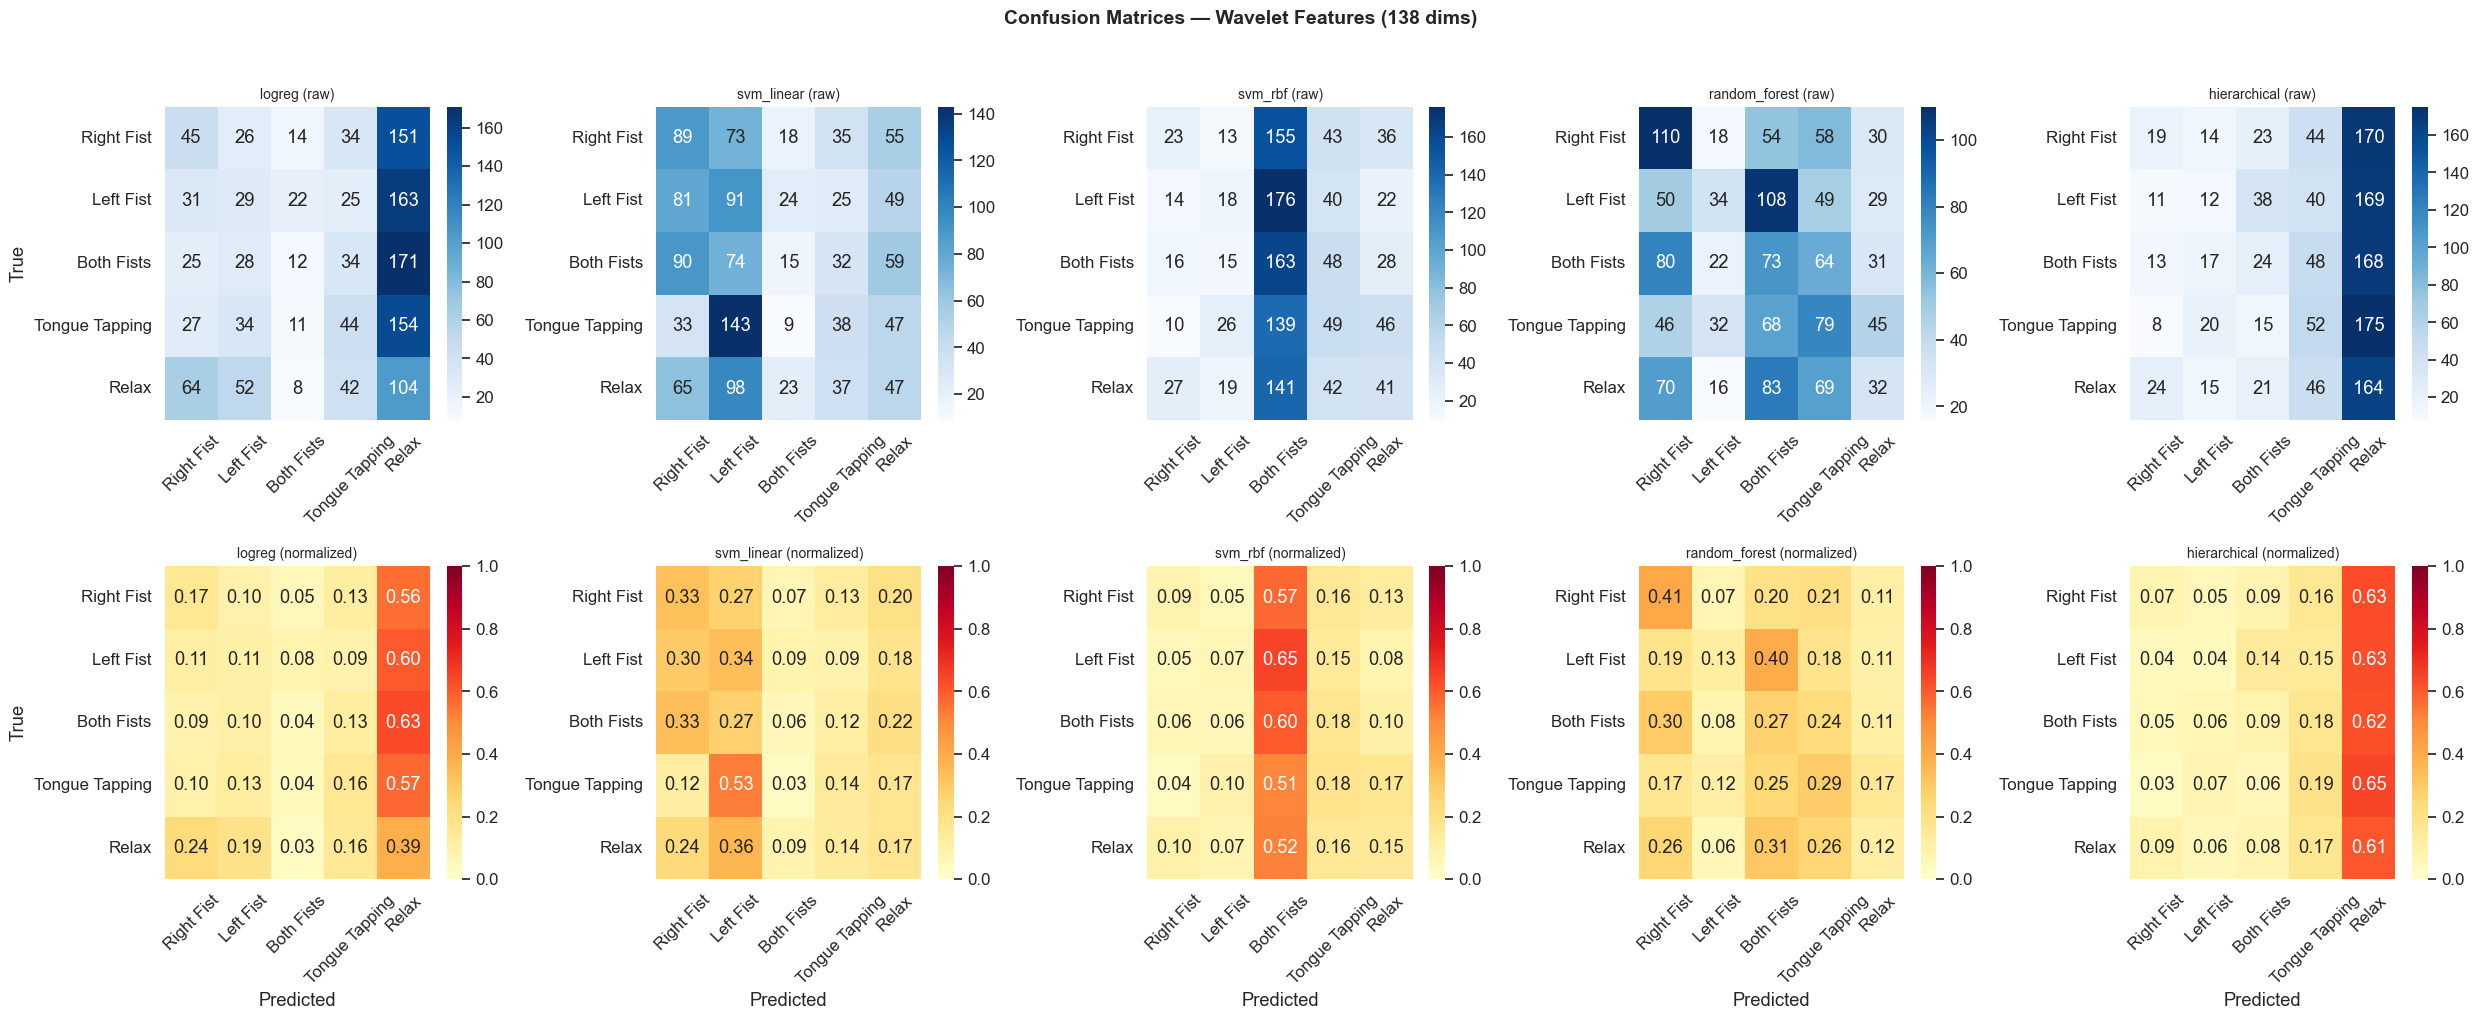

In [ ]:
model_names = list(predictions.keys())
n = len(model_names)
fig, axes = plt.subplots(2, n, figsize=(5 * n, 10))

for col, name in enumerate(model_names):
    cm_raw = confusion_matrix(y_test, predictions[name])
    cm_norm = confusion_matrix(y_test, predictions[name], normalize='true')
    
    ax = axes[0, col]
    sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    ax.set_title(f'{name} (raw)', fontsize=10)
    ax.set_ylabel('True' if col == 0 else '')
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)
    
    ax = axes[1, col]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax,
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, vmin=0, vmax=1)
    ax.set_title(f'{name} (normalized)', fontsize=10)
    ax.set_ylabel('True' if col == 0 else '')
    ax.set_xlabel('Predicted')
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

fig.suptitle('Confusion Matrices — Wavelet Features (138 dims)', fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
fig.savefig('../results/confusion_matrices_wavelet.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Per-Class F1 Heatmap

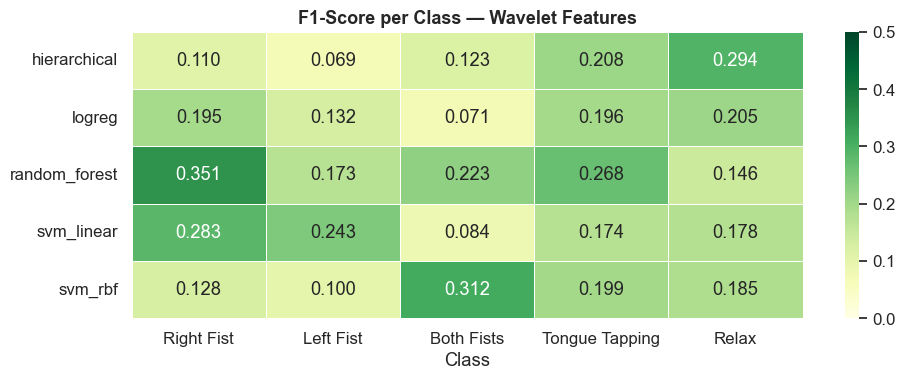

In [ ]:
per_class_rows = []
for name, y_pred in predictions.items():
    report = classification_report(y_test, y_pred, target_names=CLASS_NAMES,
                                   output_dict=True, zero_division=0)
    for cls in CLASS_NAMES:
        per_class_rows.append({'Model': name, 'Class': cls, 'F1': report[cls]['f1-score']})

df_pc = pd.DataFrame(per_class_rows)
pivot = df_pc.pivot(index='Model', columns='Class', values='F1')[CLASS_NAMES]

fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGn', ax=ax, vmin=0, vmax=0.5, linewidths=0.5)
ax.set_title('F1-Score per Class — Wavelet Features', fontsize=13, fontweight='bold')
ax.set_ylabel('')
fig.tight_layout()
fig.savefig('../results/f1_per_class_wavelet.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Wavelet Feature Importance (Random Forest)

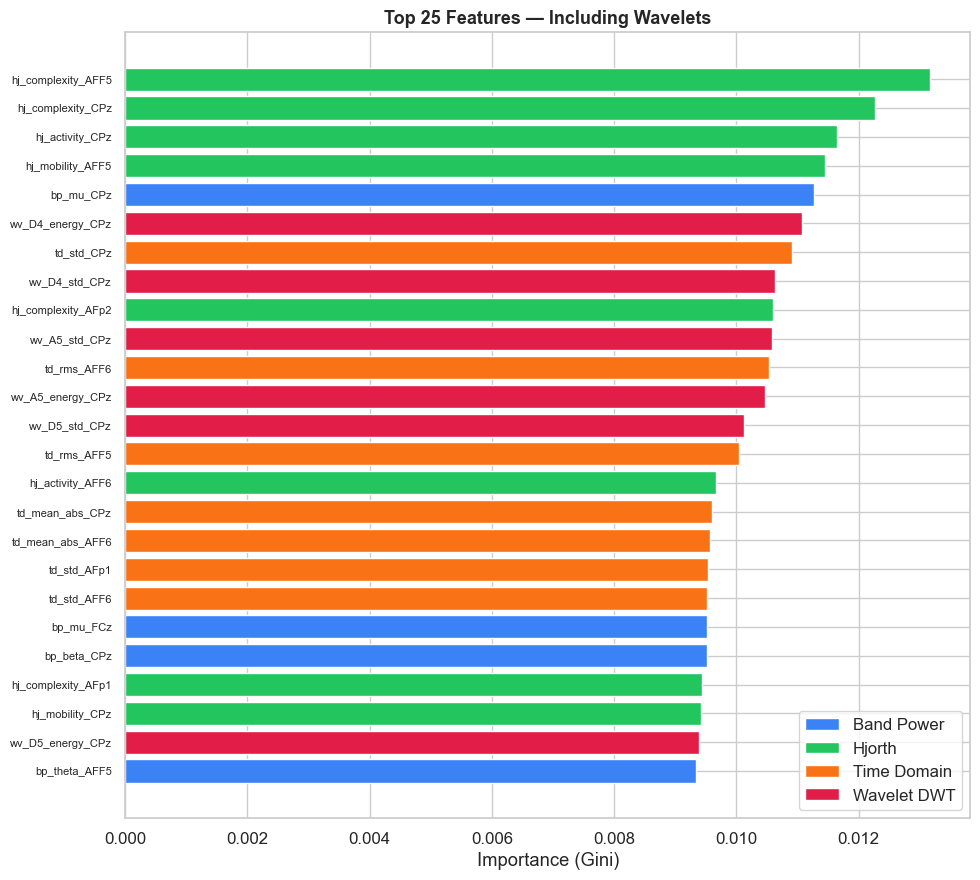


Wavelet features in top 25: 6/25 (24%)


In [ ]:
channels = ['AFF6', 'AFp2', 'AFp1', 'AFF5', 'FCz', 'CPz']
bands = ['theta', 'mu', 'beta', 'low_gamma']

feature_names = []
for band in bands:
    for ch in channels:
        feature_names.append(f'bp_{band}_{ch}')
for param in ['activity', 'mobility', 'complexity']:
    for ch in channels:
        feature_names.append(f'hj_{param}_{ch}')
for stat in ['mean_abs', 'std', 'zcr', 'rms']:
    for ch in channels:
        feature_names.append(f'td_{stat}_{ch}')
# Wavelet: 3 stats x 4 levels (D3,D4,D5,A5) x 6 channels
for ch in channels:
    for lvl in ['D3', 'D4', 'D5', 'A5']:
        for stat in ['energy', 'entropy', 'std']:
            feature_names.append(f'wv_{lvl}_{stat}_{ch}')

importances = baseline_models['random_forest'].named_steps['clf'].feature_importances_
top_k = 25
top_idx = np.argsort(importances)[-top_k:][::-1]

fig, ax = plt.subplots(figsize=(10, 9))
top_names = [feature_names[i] if i < len(feature_names) else f'f{i}' for i in top_idx]
top_imp = importances[top_idx]

colors = []
for n in top_names:
    if n.startswith('wv_'): colors.append('#e11d48')  # wavelet = red
    elif n.startswith('hj_'): colors.append('#22c55e')  # hjorth = green
    elif n.startswith('td_'): colors.append('#f97316')  # time domain = orange
    else: colors.append('#3b82f6')  # band power = blue

ax.barh(range(top_k), top_imp[::-1], color=colors[::-1], edgecolor='white')
ax.set_yticks(range(top_k))
ax.set_yticklabels(top_names[::-1], fontsize=8)
ax.set_xlabel('Importance (Gini)')
ax.set_title(f'Top {top_k} Features — Including Wavelets', fontsize=13, fontweight='bold')

from matplotlib.patches import Patch
ax.legend(handles=[
    Patch(facecolor='#3b82f6', label='Band Power'),
    Patch(facecolor='#22c55e', label='Hjorth'),
    Patch(facecolor='#f97316', label='Time Domain'),
    Patch(facecolor='#e11d48', label='Wavelet DWT'),
], loc='lower right')
fig.tight_layout()
fig.savefig('../results/feature_importance_wavelet.png', dpi=150, bbox_inches='tight')
plt.show()

# Count wavelet features in top N
n_wav_top = sum(1 for n in top_names if n.startswith('wv_'))
print(f'\nWavelet features in top {top_k}: {n_wav_top}/{top_k} ({n_wav_top/top_k:.0%})')

## 7. Wavelet Feature Breakdown by Level

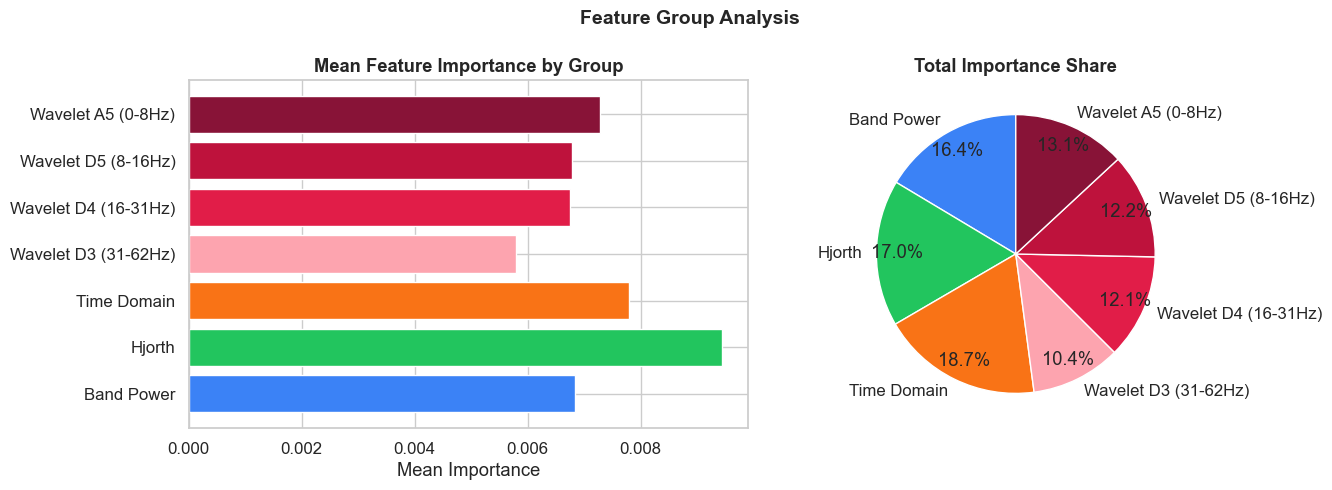

In [ ]:
# Average importance by feature group
groups = {'Band Power': [], 'Hjorth': [], 'Time Domain': [],
          'Wavelet D3 (31-62Hz)': [], 'Wavelet D4 (16-31Hz)': [],
          'Wavelet D5 (8-16Hz)': [], 'Wavelet A5 (0-8Hz)': []}

for i, name in enumerate(feature_names):
    if i >= len(importances):
        break
    imp = importances[i]
    if name.startswith('bp_'): groups['Band Power'].append(imp)
    elif name.startswith('hj_'): groups['Hjorth'].append(imp)
    elif name.startswith('td_'): groups['Time Domain'].append(imp)
    elif 'D3' in name: groups['Wavelet D3 (31-62Hz)'].append(imp)
    elif 'D4' in name: groups['Wavelet D4 (16-31Hz)'].append(imp)
    elif 'D5' in name: groups['Wavelet D5 (8-16Hz)'].append(imp)
    elif 'A5' in name: groups['Wavelet A5 (0-8Hz)'].append(imp)

group_means = {k: np.mean(v) for k, v in groups.items() if v}
group_sums = {k: np.sum(v) for k, v in groups.items() if v}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean importance
ax = axes[0]
names = list(group_means.keys())
vals = [group_means[n] for n in names]
c = ['#3b82f6', '#22c55e', '#f97316', '#fda4af', '#e11d48', '#be123c', '#881337']
ax.barh(names, vals, color=c, edgecolor='white')
ax.set_xlabel('Mean Importance')
ax.set_title('Mean Feature Importance by Group', fontweight='bold')

# Total importance share
ax = axes[1]
ax.pie(group_sums.values(), labels=group_sums.keys(), colors=c,
       autopct='%1.1f%%', startangle=90, pctdistance=0.85)
ax.set_title('Total Importance Share', fontweight='bold')

fig.suptitle('Feature Group Analysis', fontsize=14, fontweight='bold')
fig.tight_layout()
fig.savefig('../results/wavelet_group_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Hierarchical Model with Wavelets

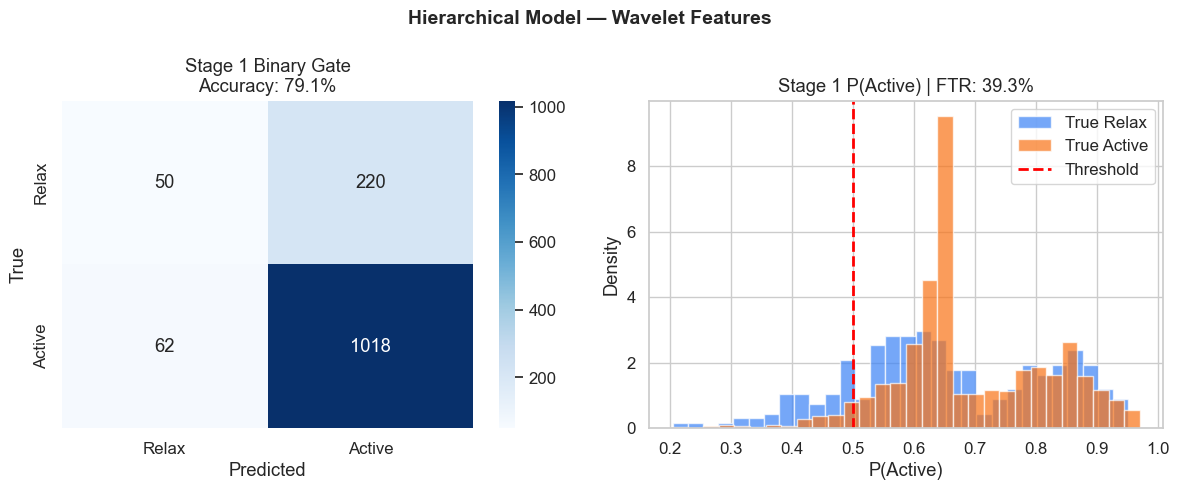

Stage 1 Accuracy: 79.1%
False Trigger Rate: 39.3%
Overall 5-class Accuracy: 20.1%


In [ ]:
y_binary = (y_test != RELAX_IDX).astype(int)
s1_proba = hier_model.stage1_model.predict_proba(X_test)
s1_pred = (s1_proba[:, 1] > 0.5).astype(int)
s1_acc = accuracy_score(y_binary, s1_pred)

relax_mask = y_test == RELAX_IDX
y_hier = predictions['hierarchical']
ftr = (y_hier[relax_mask] != RELAX_IDX).sum() / relax_mask.sum()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
cm = confusion_matrix(y_binary, s1_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Relax', 'Active'], yticklabels=['Relax', 'Active'])
ax.set_title(f'Stage 1 Binary Gate\nAccuracy: {s1_acc:.1%}')
ax.set_xlabel('Predicted'); ax.set_ylabel('True')

ax = axes[1]
ax.hist(s1_proba[relax_mask, 1], bins=30, alpha=0.7, label='True Relax', color='#3b82f6', density=True)
ax.hist(s1_proba[~relax_mask, 1], bins=30, alpha=0.7, label='True Active', color='#f97316', density=True)
ax.axvline(0.5, color='red', ls='--', lw=2, label='Threshold')
ax.set_xlabel('P(Active)'); ax.set_ylabel('Density')
ax.set_title(f'Stage 1 P(Active) | FTR: {ftr:.1%}')
ax.legend()

fig.suptitle('Hierarchical Model — Wavelet Features', fontsize=14, fontweight='bold')
fig.tight_layout()
fig.savefig('../results/hierarchical_wavelet.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Stage 1 Accuracy: {s1_acc:.1%}')
print(f'False Trigger Rate: {ftr:.1%}')
print(f'Overall 5-class Accuracy: {metrics["hierarchical"]["acc"]:.1%}')

## 9. Save Results

In [ ]:
wavelet_summary = {
    'feature_set': 'band_power + hjorth + time_domain + wavelet_dwt',
    'n_features': int(X_train.shape[1]),
    'dataset': {'train_windows': int(X_train.shape[0]), 'test_windows': int(X_test.shape[0])},
    'models': {},
}
for name in predictions:
    wavelet_summary['models'][name] = {
        'accuracy': float(metrics[name]['acc']),
        'kappa': float(metrics[name]['kappa']),
        'f1_macro': float(metrics[name]['f1']),
    }
wavelet_summary['hierarchical_stage1_acc'] = float(s1_acc)
wavelet_summary['false_trigger_rate'] = float(ftr)

with open(results_dir / 'wavelet_analysis_summary.json', 'w') as f:
    json.dump(wavelet_summary, f, indent=2)

print('Saved: wavelet_analysis_summary.json')
print('Plots: confusion_matrices_wavelet.png, f1_per_class_wavelet.png,')
print('  feature_importance_wavelet.png, wavelet_group_importance.png, hierarchical_wavelet.png')

Saved: wavelet_analysis_summary.json
Plots: confusion_matrices_wavelet.png, f1_per_class_wavelet.png,
  feature_importance_wavelet.png, wavelet_group_importance.png, hierarchical_wavelet.png
